# Leave-One-Out Cross-Validation

## Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio as rio
import sklearn as sk
import scipy as sc

In [7]:
import tqdm
#from tqdm import tqdm
from tqdm.auto import tqdm # for notebooks
tqdm.pandas()

In [8]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [9]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [10]:
import itables
from itables import show

## Importing our data

In [66]:
from pathlib import Path
result = Path("./glcms for new work").rglob("*.npz")

In [67]:
df = pd.DataFrame(result, columns=['npz_path'])

In [68]:
df.head()

npz_path
0  glcms for new work\10May2021\5rad_3step_64bins...
1  glcms for new work\10May2021\5rad_3step_64bins...
2  glcms for new work\10May2021\5rad_3step_64bins...
3  glcms for new work\10May2021\5rad_3step_64bins...
4  glcms for new work\10May2021\5rad_3step_64bins...

In [70]:
df['path_str_split'] = df['npz_path'].apply(lambda x: str(x)).str.split('\\')

In [75]:
df['phase'] = df['path_str_split'].apply(lambda x: x[1]).astype("category")

In [79]:
df['filename'] = df['path_str_split'].apply(lambda x: x[-1])

In [84]:
df[['species', 'tree_id']] = df['filename'].str.split('_').apply(lambda x: pd.Series(x[:2]))

In [91]:
df['species'] = df['species'].astype('category')

In [88]:
df['tree_id'] = df['tree_id'].str.split('.').apply(lambda x: x[0]).astype("int")

In [93]:
df_nv = df[['npz_path', 'phase', 'species', 'tree_id']]

In [95]:
df_nv.head()

npz_path      phase  \
0  glcms for new work\10May2021\5rad_3step_64bins...  10May2021   
1  glcms for new work\10May2021\5rad_3step_64bins...  10May2021   
2  glcms for new work\10May2021\5rad_3step_64bins...  10May2021   
3  glcms for new work\10May2021\5rad_3step_64bins...  10May2021   
4  glcms for new work\10May2021\5rad_3step_64bins...  10May2021   

                 species  tree_id  
0  Alstonia Angulstiloba       14  
1  Alstonia Angulstiloba       20  
2           Bridelia Sp.        2  
3           Bridelia Sp.       22  
4            Calophyllum       25

In [11]:
def acorr(filename_or_arr, *args, maxstep=50, arr_passed=False, **kwargs):
    import numpy as np
    import gc
    collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)
    if arr_passed:
        arr = filename_or_arr
    else:
        arr = np.load(filename_or_arr, allow_pickle=True)
    arr = arr.astype(np.float32)[:,:,:,0]
    acorrsarr = np.zeros((maxstep+1,maxstep*2+1,*arr.shape[2:]), dtype='float32')
    arr -= np.median(arr, axis=(0,1), keepdims=True)
    for vstep in range(0,maxstep+1):
        for hstep in range(-maxstep,maxstep+1):
            a = arr
            if vstep == 0:
                a1 = a2 = a
            elif vstep > 0:
                a1 = a[vstep:]
                a2 = a[:-vstep]
            if hstep > 0:
                a1 = a1[:,hstep:]
                a2 = a2[:,:-hstep]
            elif hstep < 0:
                a1 = a1[:,:hstep]
                a2 = a2[:,-hstep:]
            acorr = np.sum(np.multiply(a1, a2), (0, 1))
            olapsz = a1.size
            acorr /= olapsz
            acorrsarr[vstep][hstep+maxstep] = acorr
    true_points = np.argwhere(np.nan_to_num(acorrsarr))
    top_left = true_points.min(axis=0)
    bottom_right = true_points.max(axis=0)
    out = acorrsarr[top_left[0]:bottom_right[0]+1,  # plus 1 because slice isn't
                    top_left[1]:bottom_right[1]+1]  # inclusive
    collectAll()
    return out

def postfacto_fix(acorrsarr):
    true_points = np.argwhere(np.nan_to_num(acorrsarr))
    top_left = true_points.min(axis=0)
    bottom_right = true_points.max(axis=0)
    out = acorrsarr[top_left[0]:bottom_right[0]+1,  # plus 1 because slice isn't
                    top_left[1]:bottom_right[1]+1]  # inclusive
    collectAll()
    return out

In [84]:
maxstep = 50

In [ ]:
df['acorr_raw'] = df['npz_path'].parallel_apply(acorr)
df.head()

In [12]:
df['acorr_raw'] = df['acorr_raw'].progress_apply(postfacto_fix)

  0%|          | 0/67 [00:00<?, ?it/s]

In [ ]:
def acorrsarr_visualise(acorrsarr):
    maxstep = min(acorrsarr.shape[0]-1, acorrsarr.shape[1//2]-1)
    Z = acorrsarr[:,maxstep:]
    diagsabsavg_r = np.stack([np.average(np.abs(Z[::-1,:].diagonal(i)), axis=1)
                              for i in range(-Z.shape[0]+1,Z.shape[1])])    
    Z = acorrsarr[:,:maxstep+1][:,::-1]
    diagsabsavg_l = np.stack([np.average(np.abs(Z[::-1,:].diagonal(i)), axis=1)
                              for i in range(-Z.shape[0]+1,Z.shape[1])])
    diagsabsavg_diag_avg = (diagsabsavg_r + diagsabsavg_l) / 2
    diagsabsavg_diag_diff = np.abs(diagsabsavg_r - diagsabsavg_l)
    diagsabsavg = np.vstack((diagsabsavg_diag_avg, diagsabsavg_diag_diff))
    return diagsabsavg

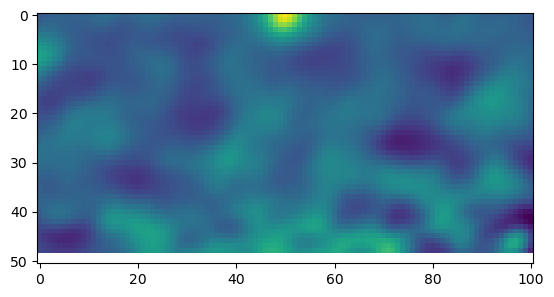

In [79]:
plt.imshow(df['acorr_raw'][45][:,:,0,0])

In [80]:
df['acorr_raw'][45][:,:,0,0]

array([[-7.5996045e-06, -1.2628151e-06,  4.9815771e-06, ...,
         4.9815771e-06, -1.2628151e-06, -7.5996045e-06],
       [ 4.6751126e-07,  6.7460842e-06,  1.1610520e-05, ...,
         3.7077443e-06, -2.9423441e-06, -8.6080727e-06],
       [ 1.5228974e-05,  2.0019408e-05,  2.1800379e-05, ...,
         4.7425469e-06, -1.1197095e-06, -5.8302644e-06],
       ...,
       [-3.8276725e-05, -4.6029836e-05, -5.2421125e-05, ...,
         5.0173177e-05, -1.5810083e-05, -8.7712084e-05],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]], dtype=float32)

In [10]:
def acorrsarr_reduce(acorrsarr):
    midpoint = acorrsarr.shape[1]//2
    Z = acorrsarr[:,midpoint:]
    diagsabsavg_r = np.stack([np.average(np.abs(Z[::-1,:].diagonal(i)), axis=1)
                              for i in range(-Z.shape[0]+1,Z.shape[1])])    
    Z = acorrsarr[:,:midpoint+1][:,::-1]
    diagsabsavg_l = np.stack([np.average(np.abs(Z[::-1,:].diagonal(i)), axis=1)
                              for i in range(-Z.shape[0]+1,Z.shape[1])])
    diagsabsavg_diag_avg = (diagsabsavg_r + diagsabsavg_l) / 2
    diagsabsavg_diag_diff = np.abs(diagsabsavg_r - diagsabsavg_l)
    diagsabsavg = np.stack((diagsabsavg_diag_avg, diagsabsavg_diag_diff))
    return diagsabsavg

In [11]:
df['acorr_diags'] = df['acorr_raw'].progress_apply(lambda x: acorrsarr_reduce(x[:,:,:,0]))

  0%|          | 0/67 [00:00<?, ?it/s]

In [12]:
def calc_glcm_stats(filename_or_arr, is_filename=True):
    if is_filename:
        arr = np.load(filename_or_arr, allow_pickle=True)
    else:
        arr = filename_or_arr
    rval = np.mean(arr, axis=(0,1))
    collectAll()
    return rval

In [13]:
df['glcm_stats'] = df['npz_path'].progress_apply(lambda x: calc_glcm_stats(x))

  0%|          | 0/67 [00:00<?, ?it/s]

In [14]:
def calc_fft(filename_or_arr, is_filename=True):
    if is_filename:
        arr = np.load(filename_or_arr, allow_pickle=True)
    else:
        arr = filename_or_arr
    rval = sc.fft.fftn(arr, axes=(0,1))
    collectAll()
    return rval

In [15]:
df['fft'] = df['npz_path'].progress_apply(lambda x: calc_fft(x))

  0%|          | 0/67 [00:00<?, ?it/s]

In [29]:
df.to_pickle("pickled_df_acorrs.pickle")

In [ ]:
### Unpickle

In [ ]:
df = pd.read_pickle("pickled_df_acorrs.pickle")

In [ ]:
df_nv = df[['filename', 'phase', 'species', 'tree_id']]

In [ ]:
df_nv.head(5)

In [ ]:
df['glcm_stats'][0].shape

In [ ]:
### Repickle without acorr

In [4]:
df_acorr = df
df = df_acorr.drop(["acorr_raw", "acorr_diags", "fft"], axis=1)

NameError: name 'df' is not defined

In [5]:
df.info()

NameError: name 'df' is not defined

In [33]:
del df_acorr

In [34]:
collectAll()

552

In [35]:
df.to_pickle("pickled_df_no_extra")